<a href="https://colab.research.google.com/github/miguelhguerrerov/miguelhguerrerov/blob/main/Extracci%C3%B3n_de_Procesos_SERCOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab para extraer información de procesos desde el SERCOP

Fuente de información: [Contrataciones Abiertas Ecuador - OCDS](https://datosabiertos.compraspublicas.gob.ec/PLATAFORMA)

Video explicativo de uso: [https://www.youtube.com/@miguelhguerrerov](https://www.youtube.com/@miguelhguerrerov)

---

## Configuración de Notebook

### Importación de librerías

In [17]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import requests
from  bs4 import BeautifulSoup
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import requests
import json
import unicodedata
import re
import time
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import matplotlib.ticker as mticker

### Importación de df base

Importación de listas de contratistas y contratantes

In [92]:
url_buyer = 'https://drive.google.com/uc?export=download&id=1PR3nz1Csc1ONflzrpdtoor_Z-jD4ZRPh'
url_supplier = 'https://drive.google.com/uc?export=download&id=1-GD-B5nUlNujqk5mWW9ttNJsjpt2NarX'
buyer2 = pd.read_csv(url_buyer)
supplier2 = pd.read_csv(url_supplier)

Importanción de mapa provincial Ecuador

In [ ]:
import os

# URL modificada del shapefile en Google Drive
url_shp = 'https://drive.google.com/uc?id=1FWymldNkKulqt18R_cwGkS3LNFXI3kuU'
url_shx = 'https://drive.google.com/uc?id=1LmnY9x__SIS-IQ0UX8jRvWffow90gHw4'
url_dbf = 'https://drive.google.com/uc?id=18QAzzcHz496n4zrUfrI6lMOIlTJ3mRGt'
# Nombre del archivo shapefile que se descargará
shapefile = 'provincias_ecuador.shp'
shx_file = 'provincias_ecuador.shx'
dbf_file = 'provincias_ecuador.dbf'
# Descargar el shapefile
!wget "{url_shp}" -O "{shapefile}"
!wget "{url_shx}" -O "{shx_file}"
!wget "{url_dbf}" -O "{dbf_file}"
# Verificar si el archivo se descargó correctamente
os.path.exists(shapefile)
os.path.exists(shx_file)
os.path.exists(dbf_file)

Importación de mapa cantonal de Ecuador

In [46]:
# URL modificada del shapefile en Google Drive
urlc_shp = 'https://drive.google.com/uc?id=1pLHVGE_xl8eJFFu3xJRBF56KcxKudRcj'
urlc_shx = 'https://drive.google.com/uc?id=12_gS9je4G6t1gMMC_S2gVRFvR7yiz08u'
urlc_dbf = 'https://drive.google.com/uc?id=1qYqlBSxtXJxwgAATfkv3LPlAIcyq-BL1'
# Nombre del archivo shapefile que se descargará
shapefilec = 'cantones_ecuador.shp'
shxc_file = 'cantones_ecuador.shx'
dbfc_file = 'cantones_ecuador.dbf'
# Descargar el shapefile
!wget "{url_shp}" -O "{shapefilec}"
!wget "{url_shx}" -O "{shxc_file}"
!wget "{urlc_dbf}" -O "{dbfc_file}"
# Verificar si el archivo se descargó correctamente
os.path.exists(shapefile)
os.path.exists(shx_file)
os.path.exists(dbf_file)

--2024-01-09 22:53:32--  https://drive.google.com/uc?id=1FWymldNkKulqt18R_cwGkS3LNFXI3kuU
Resolving drive.google.com (drive.google.com)... 172.217.164.14, 2607:f8b0:4025:803::200e
Connecting to drive.google.com (drive.google.com)|172.217.164.14|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-20-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2sgkdgo3ktqalog3muiqsipatpjds4kk/1704840750000/06561031527030378980/*/1FWymldNkKulqt18R_cwGkS3LNFXI3kuU?uuid=d60ae62b-2d92-4c33-bfa2-69c33e578fa0 [following]
--2024-01-09 22:53:34--  https://doc-00-20-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2sgkdgo3ktqalog3muiqsipatpjds4kk/1704840750000/06561031527030378980/*/1FWymldNkKulqt18R_cwGkS3LNFXI3kuU?uuid=d60ae62b-2d92-4c33-bfa2-69c33e578fa0
Resolving doc-00-20-docs.googleusercontent.com (doc-00-20-docs.googleusercontent.com)... 172.217.12.1, 2607:f8b0:4025:815::2001
Connecting to doc-00-20-docs.go

True

### Declaración de funciones

#### print_time
Función para imprimir el tiempo que se demora en ejecutar el código acompañado del texto

In [4]:
def print_time(start_time,text):
    time_now = time.time() - start_time
    print(f'[{time_now:.2f}] '+text)

#### get_contratcs
Función para obtener los resultados de una sola página desde el api del SERCOP de acuerdo a la consulta de un año, una palabra de búsqueda, una página, un provedor y contratante de búsqueda.

In [5]:

def get_contracts(year=2022, search='', page=1, buyer='', supplier='', max_retries=5, retry_delay=5):
    endpoint = "https://datosabiertos.compraspublicas.gob.ec/PLATAFORMA/api/search_ocds"
    params = {
        'year': year,
        'search': search,
        'page': page,
        'buyer': buyer,
        'supplier': supplier
    }

    for attempt in range(max_retries):
        try:
            response = requests.get(endpoint, params=params)
            if response.status_code == 200:
                print(f'Respuesta de servidor: {response.status_code}')
                return response.json()
            else:
                print(f'Error en la solicitud: {response.status_code}')
        except requests.RequestException as e:
            print(f'Error en la solicitud: {e}')

        print(f'Reintentando ({attempt + 1}/{max_retries})...')
        time.sleep(retry_delay)

    print("Número máximo de reintentos alcanzado.")
    return None

#### get_all_contracts
Función para obtener los datos de todas las páginas de un mismo año usando la función recursiva anterior

In [6]:
#Función para obtener los datos de todas las páginas de un mismo año

def get_all_contracts(year=2022,search='',page=1,buyer='',supplier=''):
    list = get_contracts(year,search,page,buyer,supplier)
    print(f'Total de paginas: {list["pages"]}')
    print(f'Total elementos: {list["total"]}')
    print('********************************************')
    total_list = []

    for page in range(1,list['pages']+1,1):
        print(f'Revisando pagina: {page}')
        new_list = get_contracts(year,search,page,buyer,supplier)
        total_list.append(new_list)
        time.sleep(1)

    return total_list

#### get_df_all_contracts
Función para obtener un dataframe de todos los contratos de un mismo año y añadir la nueva columna ['save']

In [72]:
# Función para construir un df con los datos de un año específico

def get_df_all_contracts(year=2022, search='', page=1, buyer='', supplier=''):
    list_contract = []
    total_list = get_all_contracts(year, search, page, buyer, supplier)

    for item in total_list:
        # Verificar si el item es None
        if item is None:
            continue

        for contract in item['data']:
            contract_info = {
                'id': contract['id'],
                'ocid': contract.get('ocid'),
                'year': int(contract['year']),
                'month': int(contract['month']),
                'method': contract['method'],
                'internal_type': contract['internal_type'],
                'locality': contract['locality'],
                'region': contract['region'],
                'suppliers': contract['suppliers'],
                'buyer': contract['buyer'],
                'amount': float(contract['amount']) if contract['amount'] is not None else 0,
                'date': contract['date'],
                'title': contract['title'],
                'description': contract['description'],
                'budget': float(contract['budget']) if contract['budget'] is not None else 0
            }
            list_contract.append(contract_info)
            print(f'Se añadió: {contract["title"]} a la lista')

    df = pd.DataFrame(list_contract)
    df['save'] = df['budget'] - df['amount']
    return df

#### get_df_all_year_contracts
Función para obtener un solo dataframe con la información de todos los años desde el 2015 hasta el periodo indicado

In [8]:
#Función para obtener la búsqueda para todos los años desde el 2015

def get_df_all_year_contracts(year=2023,search='',page=1,buyer='',supplier=''):
    df_all = pd.DataFrame()
    for y in range(2015,year+1,1):
        print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-')
        print(f'Buscando los datos del año: {y}')
        #df = get_df_all_contracts(y,search,page,buyer,supplier)
        time.sleep(5)
        contracts = get_contracts(y, search, page, buyer, supplier)
        if contracts['total'] != 0:
            df = get_df_all_contracts(y, search, page, buyer, supplier)
            df_all = pd.concat([df_all, df], ignore_index=True)
        else:
            print('No hay resultados para este año')
    return df_all

### Configuración de visualización de resultados

In [9]:
# Configurar opciones de visualización
pd.set_option('display.max_rows', None)  # Muestra todas las filas
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.width', None)  # Ajusta el ancho de la impresión para mostrar todas las columnas
pd.set_option('display.colheader_justify', 'center')  # Centra los encabezados de las columnas
pd.set_option('display.precision', 2)  # Establece la precisión de los números decimales
pd.set_option('display.float_format', '{:.4f}'.format) #formato de numeros float
pd.set_option('display.max_colwidth', None) # Configurar Pandas para mostrar texto completo en las columnas

## Consultas

### Consultas por entidades contratantes (Prefecturas, Municipios, Hospitales, Policía,etc)

Escribe en minúscula o mayúscula el nombre de la entidad que deseas encontrar.

In [10]:
#### @title Buscar Contratante { vertical-output: true, display-mode: "form" }
nombre = "portovelo" # @param {type:"string"}

start_time = time.time()

print_time(start_time,"--------- Inicio de proceso ---------")

print_time(start_time,"Inicio de búsqueda de contratante por nombre")
if nombre:
    nombre_empresa = nombre.upper()
    print_time(start_time,"-------------------------------")
    print_time(start_time,"Buscando coincidencia exacta")
    # Búsqueda exacta
    buyer = buyer2[buyer2['buyer_name'] == nombre_empresa]
    if not buyer.empty:
        nombre = str(buyer2['buyer_name'].head(1).values[0])
        ruc = str(buyer2['ruc_buyer'].head(1).values[0])
        print_time(start_time,'Contratante seleccionado: ' + nombre + ' con RUC: ' + ruc)
    else:
        print_time(start_time,"--------------------------------------")
        print_time(start_time,"No se encontró coincidencia exacta")
        print_time(start_time,"Buscando coincidencias similares")
        # Búsqueda de nombres similares
        empresas_similares = buyer2[buyer2['buyer_name'].str.contains(nombre_empresa, case=False, na=False)]
        #print(empresas_similares.head())
        if not empresas_similares.empty:
            print_time(start_time,"No se encontró una coincidencia exacta. Empresas similares:")

            # Usar un set para evitar nombres duplicados
            nombres_unicos = set()
            for _, row in empresas_similares.iterrows():
                if row['buyer_name'] not in nombres_unicos:
                    print_time(start_time,row['buyer_name'] + " con RUC: " + str(row['ruc_buyer']))
                    nombres_unicos.add(row['buyer_name'])
        else:
            print_time(start_time,'Empresa no encontrada')

[0.00] --------- Inicio de proceso ---------
[0.00] Inicio de búsqueda de contratante por nombre
[0.00] -------------------------------
[0.00] Buscando coincidencia exacta
[0.02] --------------------------------------
[0.02] No se encontró coincidencia exacta
[0.02] Buscando coincidencias similares
[0.04] No se encontró una coincidencia exacta. Empresas similares:
[0.04] GOBIERNO AUTONOMO DESCENTRALIZADO MUNICIPAL DE PORTOVELO con RUC: 0760000930001
[0.04] DIRECCION DISTRITAL 07D03-ATAHUALPA-PORTOVELO-ZARUMA-SALUD con RUC: 0760004920001
[0.04] UNIDAD DE ATENCION AMBULATORIA DE PORTOVELO con RUC: 0760039470001
[0.05] DIRECCION DISTRITAL 07D03-ATAHUALPA-PORTOVELO-ZARUMA EDUCACION con RUC: 0760050440001
[0.05] CENTRO DE SALUD B - PORTOVELO con RUC: 0760039470001
[0.05] CUERPO DE BOMBEROS DE PORTOVELO con RUC: 0760034670001
[0.05] EMPRESA PUBLICA MANCOMUNADA PARA LA GESTION INTEGRAL DE RESIDUOS SOLIDOS DE LOS GOBIERNOS AUTONOMOS DESCENTRALIZADOS MUNICIPALES DE ZARUMA, ATAHUALPA, PIÑAS Y PO

### Consultas por entidades contratistas (Proveedores del Estado, Empresas, Personas Naturales, Organizaciones, Empresas Públicas, etc)
Escribe en minúscula o mayúscula el nombre de la empresa o persona que deseas encontrar.

In [109]:
#### @title Buscar Contratista { vertical-output: true, display-mode: "form" }
nombre = "constructora nacional" # @param {type:"string"}

start_time = time.time()

print_time(start_time,"--------- Inicio de proceso ---------")

print_time(start_time,"Inicio de búsqueda de contratatista por nombre")
if nombre:
    nombre_empresa = nombre.upper()
    print_time(start_time,"-------------------------------")
    print_time(start_time,"Buscando coincidencia exacta")
    # Búsqueda exacta
    supplier_find = supplier2[supplier2['name'] == nombre_empresa]
    if not supplier_find.empty:
        nombre = str(supplier2['name'].head(1).values[0])
        ruc = str(supplier2['ruc_supplier'].head(1).values[0])
        print_time(start_time,'Contratante seleccionado: ' + nombre + ' con RUC: ' + ruc)
    else:
        print_time(start_time,"--------------------------------------")
        print_time(start_time,"No se encontró coincidencia exacta")
        print_time(start_time,"Buscando coincidencias similares")
        # Búsqueda de nombres similares
        empresas_similares = supplier2[supplier2['name'].str.contains(nombre_empresa, case=False, na=False)]
        #print(empresas_similares.head())
        if not empresas_similares.empty:
            print_time(start_time,"No se encontró una coincidencia exacta. Empresas similares:")

            # Usar un set para evitar nombres duplicados
            nombres_unicos = set()
            for _, row in empresas_similares.iterrows():
                if row['name'] not in nombres_unicos:
                    print_time(start_time,row['name'] + " con RUC: " + str(row['ruc_supplier']))
                    nombres_unicos.add(row['name'])
        else:
            print_time(start_time,'Empresa no encontrada')

[0.00] --------- Inicio de proceso ---------
[0.00] Inicio de búsqueda de contratatista por nombre
[0.01] -------------------------------
[0.01] Buscando coincidencia exacta
[0.02] --------------------------------------
[0.02] No se encontró coincidencia exacta
[0.02] Buscando coincidencias similares
[0.11] No se encontró una coincidencia exacta. Empresas similares:
[0.11] CONSTRUCTORA NACIONAL S.A. con RUC: 1790295567001


### Extracción de procesos de contratación por la entidad contratante deseada
Usa el formulario de la siguiente manera:


1.   ***(Requerido)*** Selecciona el año hasta donde quieres obtener los datos, el año inicial es 2015
1.   ***(Opcional)*** Escribe una palabra clave de la búsqueda.
1.   ***(Opcional)*** Copia el nombre completo de la consulta por entidades CONTRATANTES
1.   ***(Opcional)*** Copia el nombre completo de la consulta por entidades CONTRATISTAS

In [110]:
### @title Texto de título predeterminado
Ultimo_año = "2024" # @param ["2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2022", "2024"]
palabra_clave = "" # @param {type:"string"}
Contratante = "" # @param {type:"string"}
Contratista = "CONSTRUCTORA NACIONAL S.A." # @param {type:"string"}


df_result = get_df_all_year_contracts(year=int(Ultimo_año),search=palabra_clave,page=1,buyer=Contratante,supplier=Contratista)

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Buscando los datos del año: 2015
Respuesta de servidor: 200
No hay resultados para este año
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Buscando los datos del año: 2016
Respuesta de servidor: 200
Respuesta de servidor: 200
Total de paginas: 1
Total elementos: 1
********************************************
Revisando pagina: 1
Respuesta de servidor: 200
Se añadió: COTO-GADMC-0002-2016-35903 a la lista
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Buscando los datos del año: 2017
Respuesta de servidor: 200
No hay resultados para este año
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Buscando los datos del año: 2018
Respuesta de servidor: 200
Respu

### Resultados de búsqueda

Explora los diferentes resultados obtenidos

In [111]:
# @title Tabla de resultado general
df_result

,id,ocid,year,month,method,internal_type,locality,region,suppliers,buyer,amount,date,title,description,budget,save
0,1710693,ocds-5wno2w-COTO-GADMC-0002-2016-35903,2016,3,open,Cotización,CATAMAYO,LOJA,CONSTRUCTORA NACIONAL S.A.,GOBIERNO AUTONOMO DESCENTRALIZADO MUNICIPAL DE CATAMAYO,243236.0360,2016-03-18T00:00:00-05:00,COTO-GADMC-0002-2016-35903,SEGUNDA ETAPA DE ASFALTADO DE CALLES DE LA CIUDAD DE CATAMAYO,243236.0400,0.0040
1,1623218,ocds-5wno2w-LO-MTOP-L-001-2018R.-18362,2018,9,open,Licitación,LOJA,LOJA,CONSTRUCTORA NACIONAL S.A.,DIRECCIÓN DISTRITAL 11D01-LOJA-LOJA-MTOP,3904420.7413,2018-09-10T00:00:00-05:00,LO-MTOP-L-001-2018R.-18362,"REPOSICIÓN DE CARPETA ASFÁLTICA Y RECONSTRUCCIÓN DE OBRAS DE ARTE MENOR DE LA CARRETERA LOJA-CATAMAYO, E35, L=36 Km, PROVINCIA DE LOJA",4646164.3600,741743.6187
2,1622762,ocds-5wno2w-LICO-GADPS-004-2018-3277,2018,10,open,Licitación,LAGO AGRIO,SUCUMBIOS,CONSTRUCTORA NACIONAL S.A.,GOBIERNO AUTONOMO DESCENTRALIZADO DE LA PROVINCIA DE SUCUMBIOS,13029907.0848,2018-10-12T00:00:00-05:00,LICO-GADPS-004-2018-3277,MEJORAMIENTO A NIVEL DE CARPETA ASFALTICA DE LA VIA RURAL RIVEREÑOS EL GUANTA LAS DELICIAS AGUARICO III DEL CANTON LAGO AGRIO PROVINCIA DE SUCUMBIOS,14000000.0000,970092.9152
3,1583202,ocds-5wno2w-LICO-GPL-2019-002-2470,2019,11,open,Licitación,LOJA,LOJA,CONSTRUCTORA NACIONAL S.A.,GOBIERNO PROVINCIAL DE LOJA,8006975.8985,2019-11-19T00:00:00-05:00,LICO-GPL-2019-002-2470,"Rehabilitación con carpeta asfáltica de la vía Ye de Celica-Pózul-Pindal, cantones Celica y Pindal",8885700.0160,878724.1175
4,1521222,ocds-5wno2w-COTO-GADMCEL-01-2021-2792,2021,6,open,Cotización,CELICA,LOJA,CONSTRUCTORA NACIONAL S.A.,GOBIERNO AUTONOMO DESCENTRALIZADO MUNICIPAL DEL CANTON CELICA,317860.8128,2021-06-08T00:00:00-05:00,COTO-GADMCEL-01-2021-2792,"ASFALTADO DE VARIAS CALLES DE LA PARROQUIA URBANA DE CELICA (Calles Pózul, y Sabanilla pertenecientes al barrio “Los Pinos”, calles Eloy Alfaro, Jaime Roldós, barrios La Unión y Defensa Civil, calles Riobamba y Ambato del barrio 5 de Septiembre, Las calles Rene Sánchez, Matilde Hidalgo y Padre Ricardo Fernández ubicadas en el barrio San Vicente y Los Pinos, La calle de acceso al canchón municipal, donde se proyecta construir el centro de matriculación vehicular, las calles Colón vía a Sasanama y Los Cedros vía a Zapotillo).",290283.2000,-27577.6128


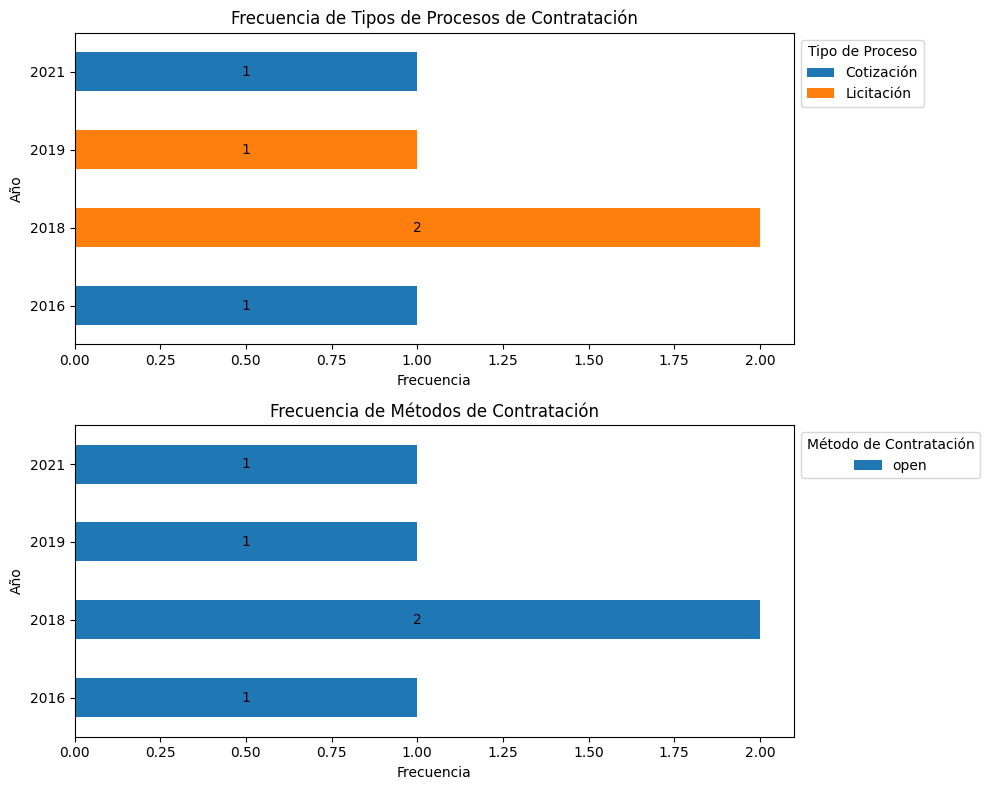

In [112]:
# @title Gráficos de barras de cantidad de contratos por tipos de procesos y métodos de contratación
# Preparar datos para gráficos de barras apiladas
grouped_internal_type = df_result.groupby(['year', 'internal_type']).size().unstack(fill_value=0)
grouped_method = df_result.groupby(['year', 'method']).size().unstack(fill_value=0)

# Crear una figura con dos subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Función para añadir etiquetas en cada segmento de barra apilada
def add_labels(ax, grouped_data):
    for i, (year, row) in enumerate(grouped_data.iterrows()):
        cum_values = 0
        for col in grouped_data.columns:
            value = row[col]
            if value > 0:
                ax.text(cum_values + value/2, i, f'{int(value)}', va='center', ha='center')
                cum_values += value

# Primer gráfico: Frecuencia de Tipos de Procesos de Contratación
grouped_internal_type.plot(kind='barh', stacked=True, ax=axs[0], legend=False)
add_labels(axs[0], grouped_internal_type)
axs[0].set_title('Frecuencia de Tipos de Procesos de Contratación')
axs[0].set_ylabel('Año')
axs[0].set_xlabel('Frecuencia')
axs[0].legend(title='Tipo de Proceso', loc='upper left', bbox_to_anchor=(1, 1))

# Segundo gráfico: Frecuencia de Métodos de Contratación
grouped_method.plot(kind='barh', stacked=True, ax=axs[1], legend=False)
add_labels(axs[1], grouped_method)
axs[1].set_title('Frecuencia de Métodos de Contratación')
axs[1].set_ylabel('Año')
axs[1].set_xlabel('Frecuencia')
axs[1].legend(title='Método de Contratación', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

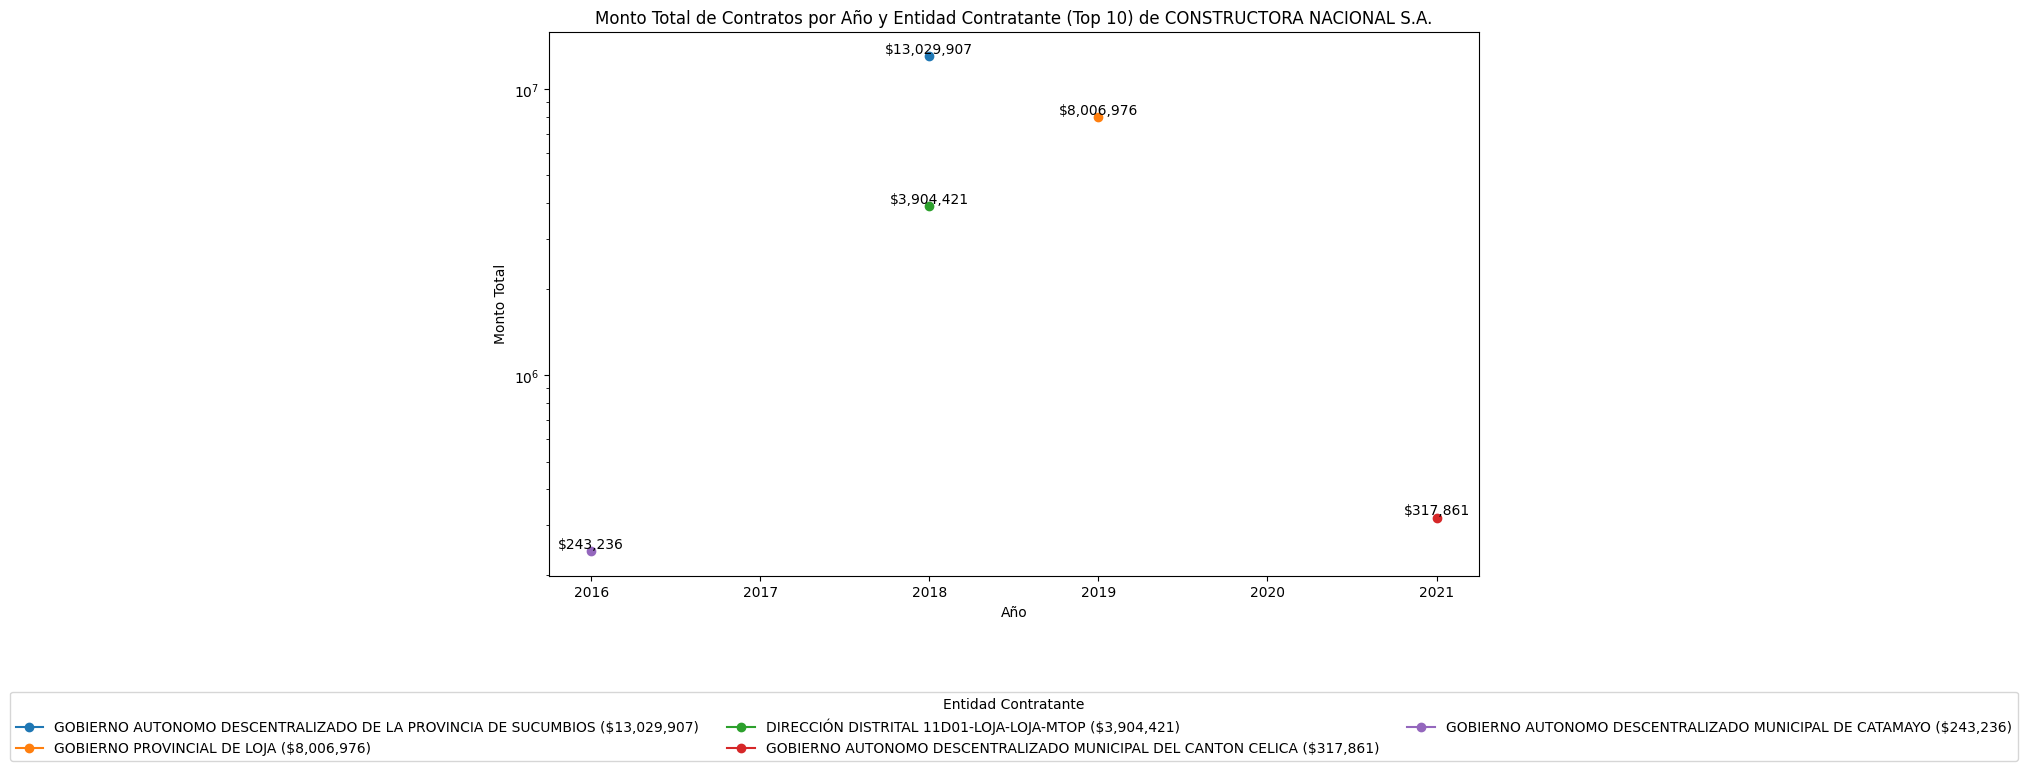

In [113]:
# @title Gráfico de montos totales por año y por entidades contratantes

top_buyers = df_result.groupby('buyer')['amount'].sum().nlargest(10)

fig, ax = plt.subplots(figsize=(12, 8))

for buyer in top_buyers.index:
    df_grouped = df_result[df_result['buyer'] == buyer].groupby('year')['amount'].sum()
    df_grouped.plot(ax=ax, kind='line', label=f'{buyer} (${top_buyers[buyer]:,.0f})', marker='o')
    # Cambiar iteritems() por items()
    for year, amount in df_grouped.items():
        ax.text(year, amount, f'${amount:,.0f}', ha='center', va='bottom')

# Formato de dólar en el eje y
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Escala logarítmica para el eje y
ax.set_yscale('log')

# Mover la leyenda debajo del gráfico y ajustar el layout
ax.legend(title='Entidad Contratante', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.subplots_adjust(bottom=0.2)  # Ajustar el margen inferior para acomodar la leyenda

plt.title(f'Monto Total de Contratos por Año y Entidad Contratante (Top 10) de {Contratista}')
plt.xlabel('Año')
plt.ylabel('Monto Total')
plt.show()

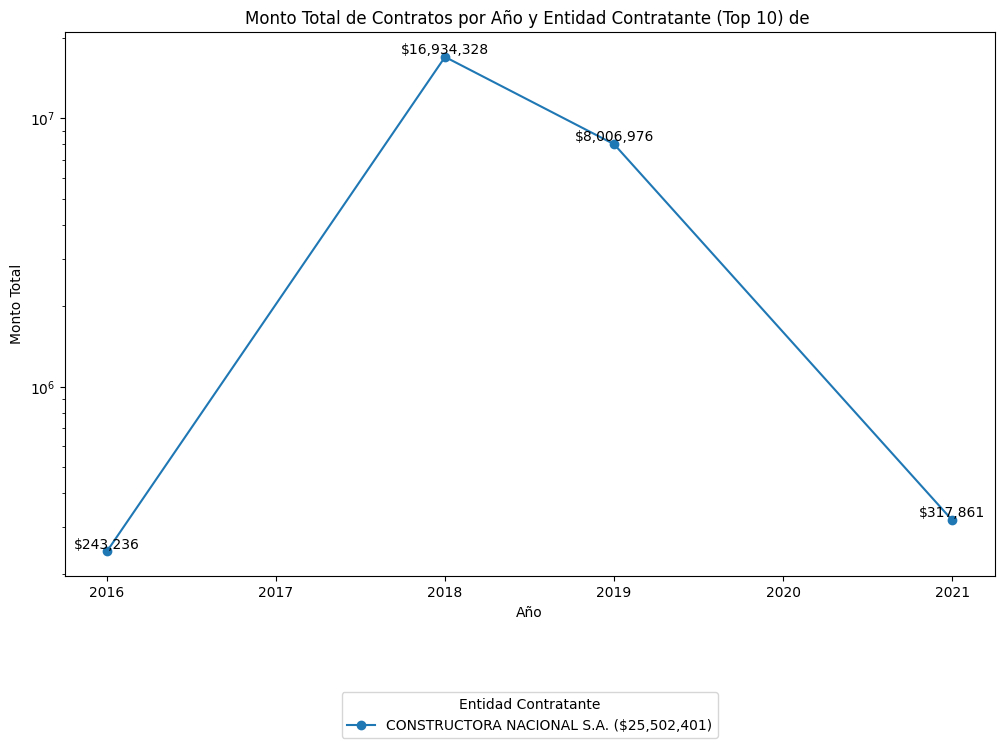

In [114]:
# @title Gráfico de montos totales por año y por contratista

top_suppliers = df_result.groupby('suppliers')['amount'].sum().nlargest(10)

fig, ax = plt.subplots(figsize=(12, 8))

for supplier in top_suppliers.index:
    df_grouped = df_result[df_result['suppliers'] == supplier].groupby('year')['amount'].sum()
    df_grouped.plot(ax=ax, kind='line', label=f'{supplier} (${top_suppliers[supplier]:,.0f})', marker='o')
    # Cambiar iteritems() por items()
    for year, amount in df_grouped.items():
        ax.text(year, amount, f'${amount:,.0f}', ha='center', va='bottom')

# Formato de dólar en el eje y
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Escala logarítmica para el eje y
ax.set_yscale('log')

# Mover la leyenda debajo del gráfico y ajustar el layout
ax.legend(title='Entidad Contratante', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.subplots_adjust(bottom=0.2)  # Ajustar el margen inferior para acomodar la leyenda

plt.title(f'Monto Total de Contratos por Año y Entidad Contratante (Top 10) de {Contratante}')
plt.xlabel('Año')
plt.ylabel('Monto Total')
plt.show()

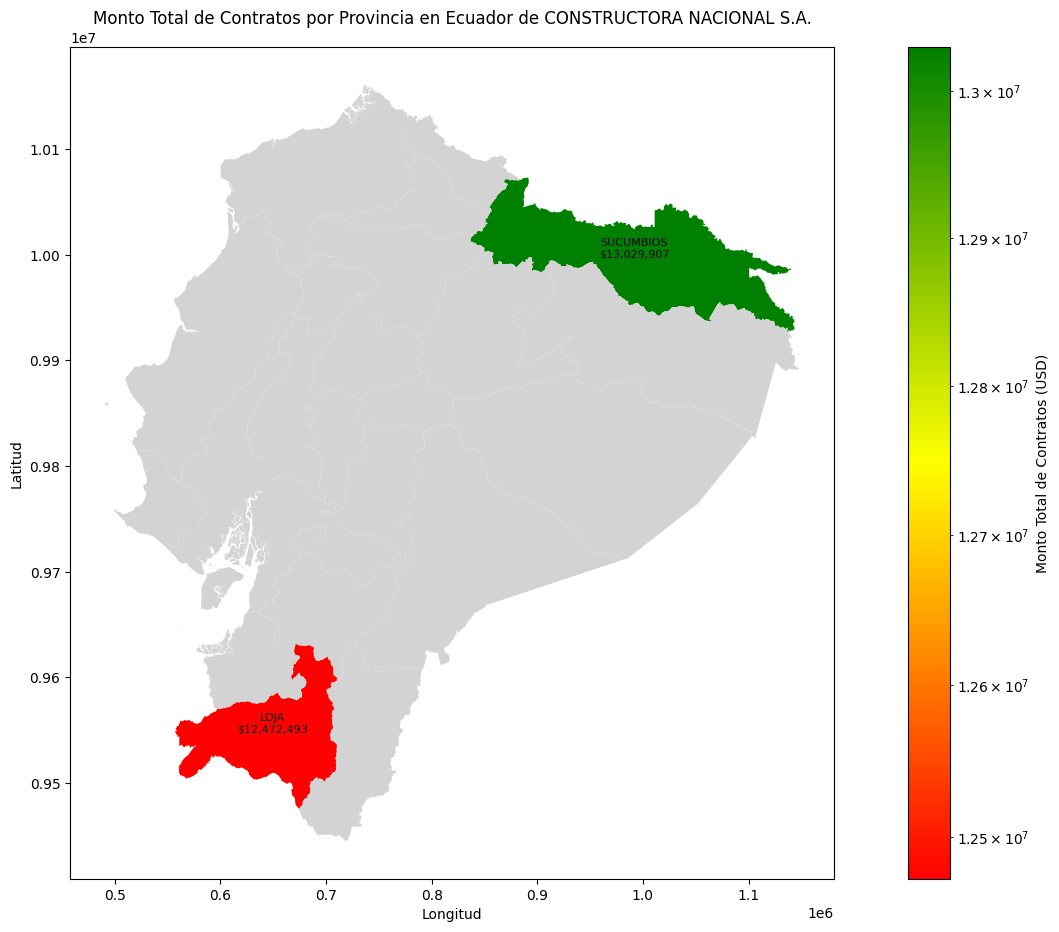

In [115]:
# @title Mapa por provincias de mayor monto contratado

# Cargar el shapefile de las provincias de Ecuador
gdf = gpd.read_file('provincias_ecuador.shp')

# Sumar los montos por provincia en df_result
df_sum = df_result.groupby('region')['amount'].sum().reset_index()

# Asegurarse de que todas las provincias estén representadas en df_sum
provincias = gdf['DPA_DESPRO'].unique()
df_sum = df_sum.set_index('region').reindex(provincias).reset_index()

# Asignar NaN a provincias sin datos en lugar de 0
df_sum['amount'] = df_sum['amount'].replace(0, np.nan)

# Fusionar el DataFrame con el GeoDataFrame
gdf_merged = gdf.merge(df_sum, left_on='DPA_DESPRO', right_on='region')

# Excluir la provincia 'GALAPAGOS' si su monto es NaN o 0
gdf_merged = gdf_merged[~((gdf_merged['DPA_DESPRO'] == 'GALAPAGOS') & (gdf_merged['amount'].isna()))]

# Crear un mapa coroplético con escala logarítmica y tres colores (rojo, amarillo, verde)
cmap = mcolors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])

# Plotear el mapa
dpi = 100  # Densidad de píxeles por pulgada
fig, ax = plt.subplots(1, 1, figsize=(1920 / dpi, 1080 / dpi), dpi=dpi)
norm = mcolors.LogNorm(vmin=df_sum['amount'].min(), vmax=df_sum['amount'].max())
gdf_merged.plot(column='amount', ax=ax, legend=False, cmap=cmap, missing_kwds={'color': 'lightgrey'}, norm=norm)

# Añadir etiquetas para cada provincia
for idx, row in gdf_merged.iterrows():
    if pd.notnull(row['amount']):
        ax.annotate(text=f"{row['DPA_DESPRO']}\n${row['amount']:,.0f}",
                    xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                    horizontalalignment='center', fontsize=8)

# Crear la barra de color y aplicar formato de dólares
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Matplotlib dummy array
cbar = plt.colorbar(sm, ax=ax, format=mticker.StrMethodFormatter('${x:,.0f}'))
cbar.set_label('Monto Total de Contratos (USD)')

if Contratante:
  plt.title(f'Monto Total de Contratos por Provincia en Ecuador de {Contratante}')
elif Contratista:
  plt.title(f'Monto Total de Contratos por Provincia en Ecuador de {Contratista}')
else:
  plt.title(f'Monto Total de Contratos por Provincia en Ecuador de {Contratante} y {Contratista}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

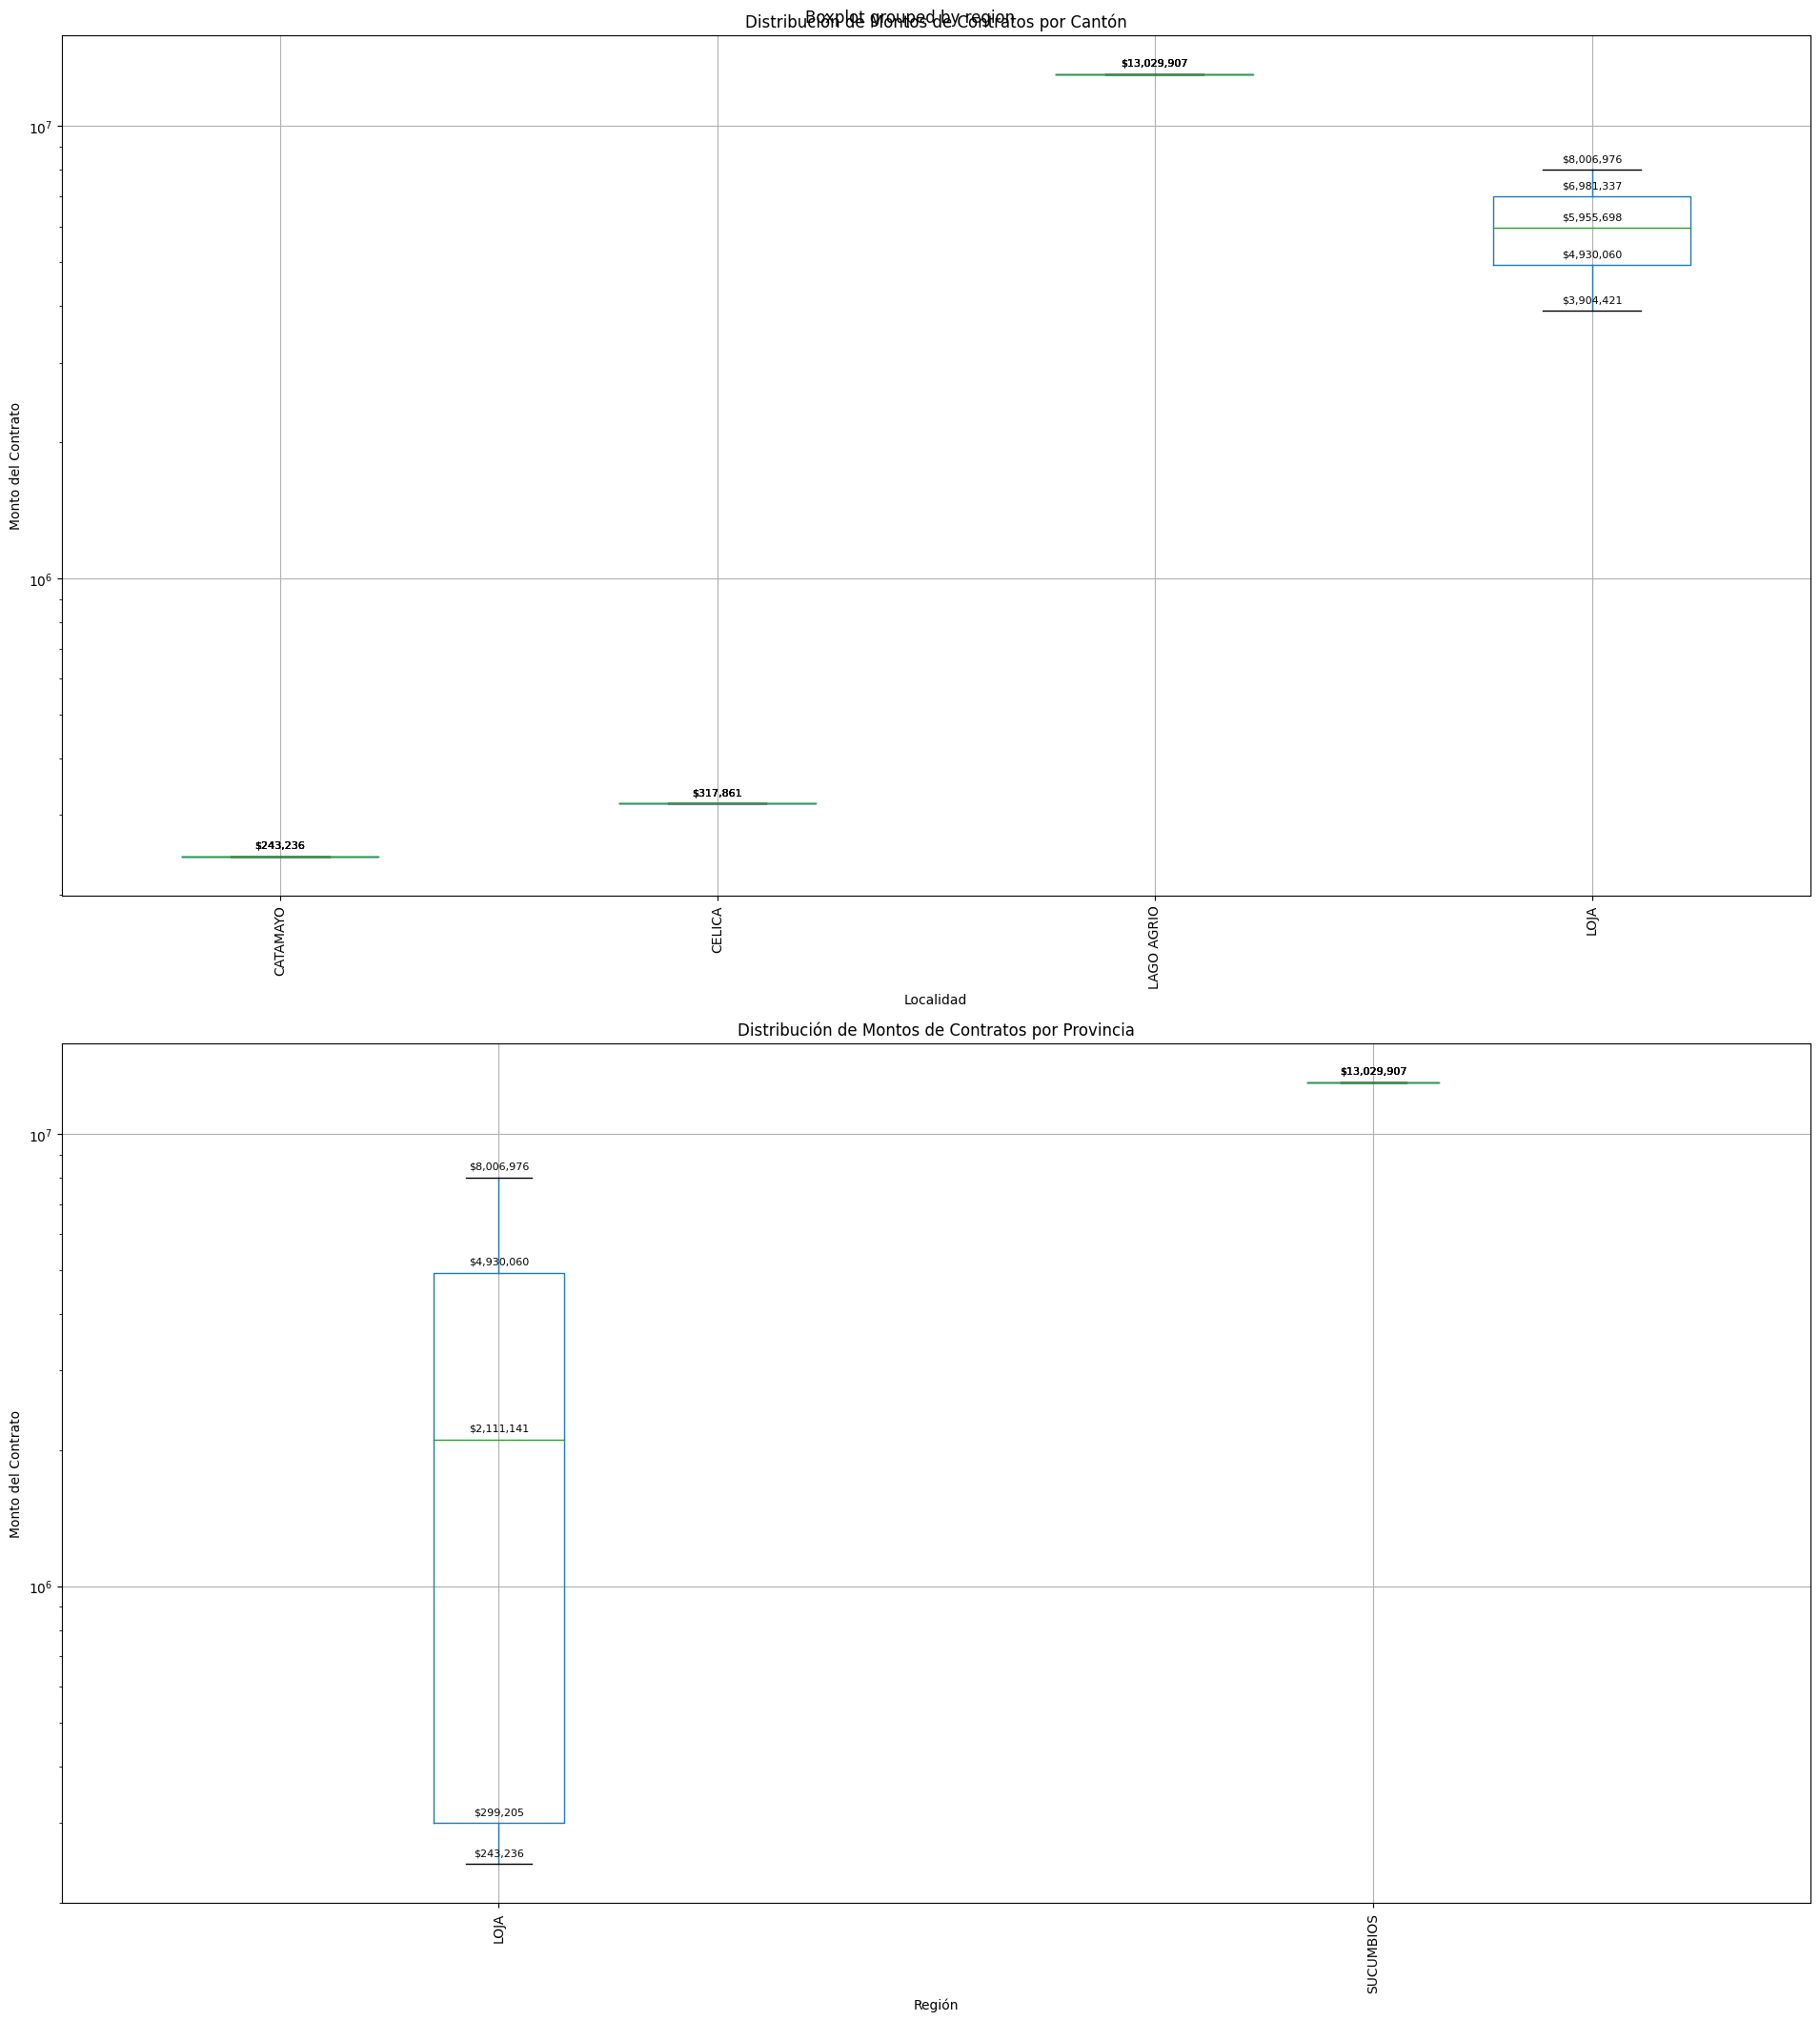

In [116]:
# @title Gráfico de Distribución de montos de contratos

# Ajuste para dimensiones de 1920x1080 px por subplot
fig_width_px = 1920
fig_height_px = 1080
dpi = 100  # Densidad de pixeles por pulgada
fig_width = fig_width_px / dpi
fig_height = fig_height_px / dpi

# Crear una figura con dos subplots, uno sobre el otro
fig, axs = plt.subplots(2, 1, figsize=(fig_width, fig_height*2), dpi=dpi)

# Función para añadir etiquetas de valores estadísticos en un boxplot
# (La misma función que se proporcionó anteriormente)

# Boxplot de montos de contratos por localidad
df_result.boxplot(column='amount', by='locality', ax=axs[0])
add_stats_labels(axs[0], df_result, 'locality', 'amount')
# Título y etiquetas
axs[0].set_title(f'Distribución de Montos de Contratos por Cantón')
axs[0].set_xlabel('Localidad')
axs[0].set_ylabel('Monto del Contrato')
axs[0].set_yscale('log')  # Escala logarítmica
# Rotar etiquetas
for label in axs[0].get_xticklabels():
    label.set_rotation(90)

# Boxplot de montos de contratos por región
df_result.boxplot(column='amount', by='region', ax=axs[1])
add_stats_labels(axs[1], df_result, 'region', 'amount')
# Título y etiquetas
axs[1].set_title(f'Distribución de Montos de Contratos por Provincia')
axs[1].set_xlabel('Región')
axs[1].set_ylabel('Monto del Contrato')
axs[1].set_yscale('log')  # Escala logarítmica
# Rotar etiquetas
for label in axs[1].get_xticklabels():
    label.set_rotation(90)

plt.tight_layout()
plt.show()

## Descargas de documentos

In [82]:
# @title Descargar excel con contratos

if Contratista:
  df_result.to_excel(f'contratos_{Contratista}.xlsx')
elif Contratante:
  df_result.to_excel(f'contratos_{Contratante}.xlsx')
else:
  df_result.to_excel(f'contratos_{Contratante}_{Contratista}.xlsx')